# Response Analysis

In [2]:
import pandas as pd
import os
from pathlib import Path
from typing import Dict, List

In [3]:
def get_llm_output_structure() -> Dict[str, List[str]]:
    """
    Generate a dictionary mapping folders in llm_output to their contained file paths.
    
    Returns:
        Dict[str, List[str]]: Dictionary with folder names as keys and lists of file paths as values
    """
    # Get the llm_output directory path
    llm_output_dir = Path("../benchmark/llm_output")
    
    # Initialize result dictionary
    output_structure: Dict[str, List[str]] = {}
    
    # Walk through the directory
    for folder in llm_output_dir.iterdir():
        if folder.is_dir():
            # Get all files in the folder
            files = [
                str(file.relative_to(llm_output_dir))
                for file in folder.glob("*")
                if file.is_file()
            ]
            # Add to dictionary with folder name as key
            output_structure[folder.name] = sorted(files)
            
    return output_structure

In [5]:
# Example usage:
llm_output_structure = get_llm_output_structure()
for folder, files in llm_output_structure.items():
    print(f"\n{folder}:")
    for file in files[:5]:  # Show first 5 files
        print(f"  - {file}")
    if len(files) > 5:
        print("  ...")
    break


qwen2.5_7b:
  - qwen2.5_7b/CHUNKS_admin_0_1.txt
  - qwen2.5_7b/CHUNKS_admin_1_1.txt
  - qwen2.5_7b/CHUNKS_admin_2_1.txt
  - qwen2.5_7b/CHUNKS_admin_3_1.txt
  - qwen2.5_7b/CHUNKS_admin_4_1.txt
  ...


In [6]:
def read_llm_response(file_path: str) -> str:
    """
    Read the contents of an LLM response file.
    
    Args:
        file_path: Relative path to the file within llm_output directory
        
    Returns:
        str: Contents of the file
        
    Raises:
        FileNotFoundError: If the file doesn't exist
    """
    # Construct full path
    full_path = Path("../benchmark/llm_output") / file_path
    
    try:
        return full_path.read_text(encoding='utf-8')
    except FileNotFoundError:
        raise FileNotFoundError(f"Response file not found: {full_path}")

# Get first file from first model folder as example
first_model = next(iter(llm_output_structure))
first_file = llm_output_structure[first_model][0]

# Read and print contents
print(f"Contents of {first_file}:")
print("-" * 40)
print(read_llm_response(first_file))

Contents of qwen2.5_7b/CHUNKS_admin_0_1.txt:
----------------------------------------
CoRAG (Contextual Rank-and-Generate) fundamentally differs from traditional Retrieval-Augmented Generation (RAG) architectures by addressing key limitations related to multi-hop reasoning. Specifically, CoRAG introduces a contextual ranking mechanism that enhances the handling of complex queries requiring multiple pieces of information.

In traditional RAG architectures, the retrieval process often relies on keyword-based matching, which can struggle with queries that require linking distant or less explicit connections between documents. This is where CoRAG steps in by incorporating a more sophisticated ranking approach. According to the data provided, "RankRAG is a method that unifies context ranki[ing] and generation" [Data: Relationships (18)]. Through this mechanism, CoRAG can better identify relevant contexts across different documents, thereby facilitating multi-hop reasoning.

Moreover, tradit

In [156]:
n_questions = []
n_models = []
n_texts = []
n_access_levels = []
n_response_types = []
n_paths = []
for k,v in llm_output_structure.items():
    for text in v:
        qid = text.split('/')[-1].split('_')[-2]
        response_type = '_'.join(text.split('/')[-1].split('_')[:-3])
        access_level = text.split('/')[-1].split('_')[-3:-2][0]
        full_path = Path("../benchmark/llm_output") / text
        try:
            txt = full_path.read_text(encoding='utf-8')
        except FileNotFoundError:
            raise FileNotFoundError(f"Response file not found: {full_path}")

        n_questions.append(qid)
        n_models.append(k)
        n_texts.append(txt)
        n_access_levels.append(access_level)
        n_response_types.append(response_type)
        n_paths.append(text)

In [280]:
df = pd.DataFrame([n_questions, n_models, n_access_levels, n_response_types, n_paths, n_texts]).T
df.columns = ['question_id', 'model', 'access_level', 'response_type', 'path', 'text']
df.tail()

,question_id,model,access_level,response_type,path,text
395,5,deepseek-r1_32b,user1,KG_ONLY,deepseek-r1_32b/KG_ONLY_user1_5_1.txt,"<think>\nOkay, so I'm trying to understand whe..."
396,6,deepseek-r1_32b,user1,KG_ONLY,deepseek-r1_32b/KG_ONLY_user1_6_1.txt,"<think>\nOkay, so I'm trying to understand why..."
397,7,deepseek-r1_32b,user1,KG_ONLY,deepseek-r1_32b/KG_ONLY_user1_7_1.txt,"<think>\nOkay, so I'm trying to figure out how..."
398,8,deepseek-r1_32b,user1,KG_ONLY,deepseek-r1_32b/KG_ONLY_user1_8_1.txt,"<think>\nOkay, so I'm trying to figure out how..."
399,9,deepseek-r1_32b,user1,KG_ONLY,deepseek-r1_32b/KG_ONLY_user1_9_1.txt,"<think>\nOkay, so I'm trying to understand whe..."


# Create Embedding

## Rank Answers

In [281]:
from pydantic import BaseModel, Field
from typing import List, Dict, Optional
import openai
from pathlib import Path
import os

class ResponseEvaluation(BaseModel):
    """Model for a single response evaluation."""
    model_name: str = Field(..., description="Name of the LLM model")
    rank: int = Field(..., description="Rank of the response (1 being best)")
    score: float = Field(..., ge=0, le=10, description="Score out of 10")
    reasoning: str = Field(..., description="Detailed explanation for the ranking")

class QuestionEvaluation(BaseModel):
    """Model for evaluating all responses to a single question."""
    question_id: str = Field(..., description="ID of the question (e.g., 'admin_1')")
    access_level: str = Field(..., description="Access level (admin/user)")
    question_type: str = Field(..., description="Type of response (CHUNKS/DOCUMENT_LEVEL/etc)")
    evaluations: List[ResponseEvaluation] = Field(..., description="List of response evaluations")
    meta_analysis: str = Field(..., description="Overall analysis of all responses")

In [282]:
import json

def evaluate_responses_for_question(
    question_id: str,
    access_level: str,
    response_type: str,
    responses: Dict[str, str]
) -> QuestionEvaluation:
    """
    Evaluate all responses for a single question using GPT-4.
    
    Args:
        question_id: Question identifier
        access_level: Access level (admin/user)
        response_type: Type of response (CHUNKS/DOCUMENT_LEVEL/etc)
        responses: Dictionary mapping model names to their responses
        
    Returns:
        QuestionEvaluation: Structured evaluation of all responses
    """
    # Construct prompt for GPT-4
    prompt = f"""You are an expert evaluator of LLM responses. Please analyze and rank the following responses to the same question.
    Question ID: {question_id}
    Access Level: {access_level}
    Response Type: {response_type}

    Responses to evaluate:
    {'-' * 50}
    """
    
    for model_name, response in responses.items():
        prompt += f"\n{model_name}:\n{response}\n{'-' * 50}\n"
    
    prompt += """\nPlease evaluate each response based on:
    1. Accuracy and factual correctness
    2. Completeness of the answer
    3. Clarity and coherence
    4. Relevance to the question
    5. Proper use of available context

    Provide a ranking from best to worst, with scores (0-10) and detailed explanations.
    Format your response in a structured way that can be parsed into the following JSON schema:
    {
        "evaluations": [
            {
                "model_name": "model name",
                "rank": rank number,
                "score": score (0-10),
                "reasoning": "detailed explanation"
            }
        ],
        "meta_analysis": "overall analysis of patterns and differences between responses"
    }
    
    Check the response json format before returning it.
    """

    # Get evaluation from GPT-4
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are an expert evaluator of LLM responses."},
            {"role": "user", "content": prompt}
        ],
        response_format={ "type": "json_object" }
    )
    
    # Parse response
    evaluation_data = response.choices[0].message.content
    
    # Create QuestionEvaluation object
    # return QuestionEvaluation(
    #     question_id=question_id,
    #     access_level=access_level,
    #     question_type=response_type,
    #     **evaluation_data
    # )
    return evaluation_data

def evaluate_all_questions(q_n_a: pd.DataFrame) -> List[QuestionEvaluation]:
    """
    Evaluate all questions across different models and response types.
    
    Args:
        embeddings_df: DataFrame containing response embeddings and metadata
        
    Returns:
        List[QuestionEvaluation]: List of evaluations for all questions
    """
    evaluations = []
    results = {}

    # ROWs: 'question_id', 'model', 'access_level', 'response_type', 'text'
    
    # Process each unique combination
    i = 0
    for (qid, access, rtype), group in df.groupby(['question_id', 'access_level', 'response_type']):
        # Get responses for each model
        responses = {}
        for _, row in group.iterrows():
            # response_text = read_llm_response(f"{row['model']}/{row['path']}")
            responses[row['model']] = row['text']
            
        # Get evaluation
        # print(responses)
        # print(row)
        evaluation = evaluate_responses_for_question(qid, access, rtype, responses)
        try:
            eval_dict = json.loads(evaluation)
            # evaluations_dicts.append(eval_dict)
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")
        
        eval_dict['params'] = {'qid': qid, 'access': access, 'rtype': rtype}
        eval_dict['qid'] = qid
        results[i] = eval_dict
        # evaluations.append(evaluation)
        
        # Save individual evaluation
        # output_path = Path(f"../benchmark/output/evaluations/{qid}_{rtype}.json")
        # output_path.parent.mkdir(parents=True, exist_ok=True)
        # output_path.write_text(evaluation.model_dump_json(indent=2))
        i += 1
    
    return results # evaluations

# Run evaluations
evaluations = evaluate_all_questions(df)

Error parsing JSON: Unterminated string starting at: line 25 column 26 (char 1798)


In [324]:
evaluations

{0: {'evaluations': [{'model_name': 'mistral-small_24b',
    'rank': 1,
    'score': 9,
    'reasoning': 'This response provides a well-structured and comprehensive comparison of CoRAG and traditional RAG architectures. It clearly outlines multiple key differences, such as multi-hop reasoning, contextual awareness, and iterative retrieval. The use of bullet points enhances clarity and allows for easy understanding. It thoroughly addresses the question with specific limitations CoRAG overcomes while maintaining relevance throughout the discussion.'},
   {'model_name': 'qwen2.5_7b',
    'rank': 2,
    'score': 8,
    'reasoning': "This response discusses important aspects of CoRAG's advantages over traditional RAG, particularly focusing on multi-hop reasoning. It is detailed and provides good insights, although it is slightly less structured than the top-ranked response. Some phrases can be seen as repetitive, which affects clarity but still maintains a high degree of factual correctness

In [319]:
dfs = []
errors = {}
for idx, ev in evaluations.items():
    try:
        df = pd.DataFrame(ev['evaluations'])
        # Add question metadata
        df['question_id'] = ev['qid']
        df['access_level'] = ev['params']['access']
        df['response_type'] = ev['params']['rtype']
        df['meta_analysis'] = ev['meta_analysis']
        
        # Add to list
        dfs.append(df)
    except Exception as e:
        print(f"Error: {e}")
        errors[idx] = ev
        next

Error: 'str' object has no attribute 'keys'
Error: 'meta_analysis'


In [320]:
combined_df = pd.concat(dfs, ignore_index=True)
combined_df.head()

,model_name,rank,score,reasoning,question_id,access_level,response_type,meta_analysis
0,mistral-small_24b,1,9,This response provides a well-structured and c...,0,admin,CHUNKS,The evaluations highlight that the higher-rank...
1,qwen2.5_7b,2,8,This response discusses important aspects of C...,0,admin,CHUNKS,The evaluations highlight that the higher-rank...
2,qwen2.5_3b,3,7,This response effectively highlights how CoRAG...,0,admin,CHUNKS,The evaluations highlight that the higher-rank...
3,deepseek-r1_32b,4,6,This response provides a decent overview of th...,0,admin,CHUNKS,The evaluations highlight that the higher-rank...
4,deepseek-r1_1.5b,5,5,"This response is the least effective, as it re...",0,admin,CHUNKS,The evaluations highlight that the higher-rank...


In [323]:
print("\nSummary by model:")
summary = combined_df.groupby('model_name').agg({
    'score': ['mean', 'std', 'count'],
    'rank': 'mean'
}).round(2)
print(summary)

# Save to CSV
combined_df.to_csv('./results/combined_evaluations.csv', index=False)


Summary by model:
                  score              rank
                   mean   std count  mean
model_name                               
deepseek-r1_1.5b   5.83  0.86    78  3.97
deepseek-r1_32b    5.53  1.43    78  4.23
mistral-small_24b  8.45  1.31    78  1.63
qwen2.5_3b         6.29  1.14    78  3.58
qwen2.5_7b         8.47  0.64    78  1.59


In [322]:
errors.keys()

dict_keys([5, 44])

In [326]:
import seaborn as sns
import matplotlib.pyplot as plt

def config_seaborn():
    palette = ["#fa00e1", "#0019fa" , "#00fa15", "#00faee", "#faaf00", "#9200fa", "#edfa00"]
    sns_palette = sns.color_palette(palette, len(palette))
    sns.set_style('whitegrid')
    sns.set_context('talk')

    return sns_palette

/var/folders/m1/mg27xm293zg8r4pj5rd35m6r0000gn/T/ipykernel_91890/3142893759.py:7: UserWarning:

The palette list has more values (7) than needed (4), which may not be intended.



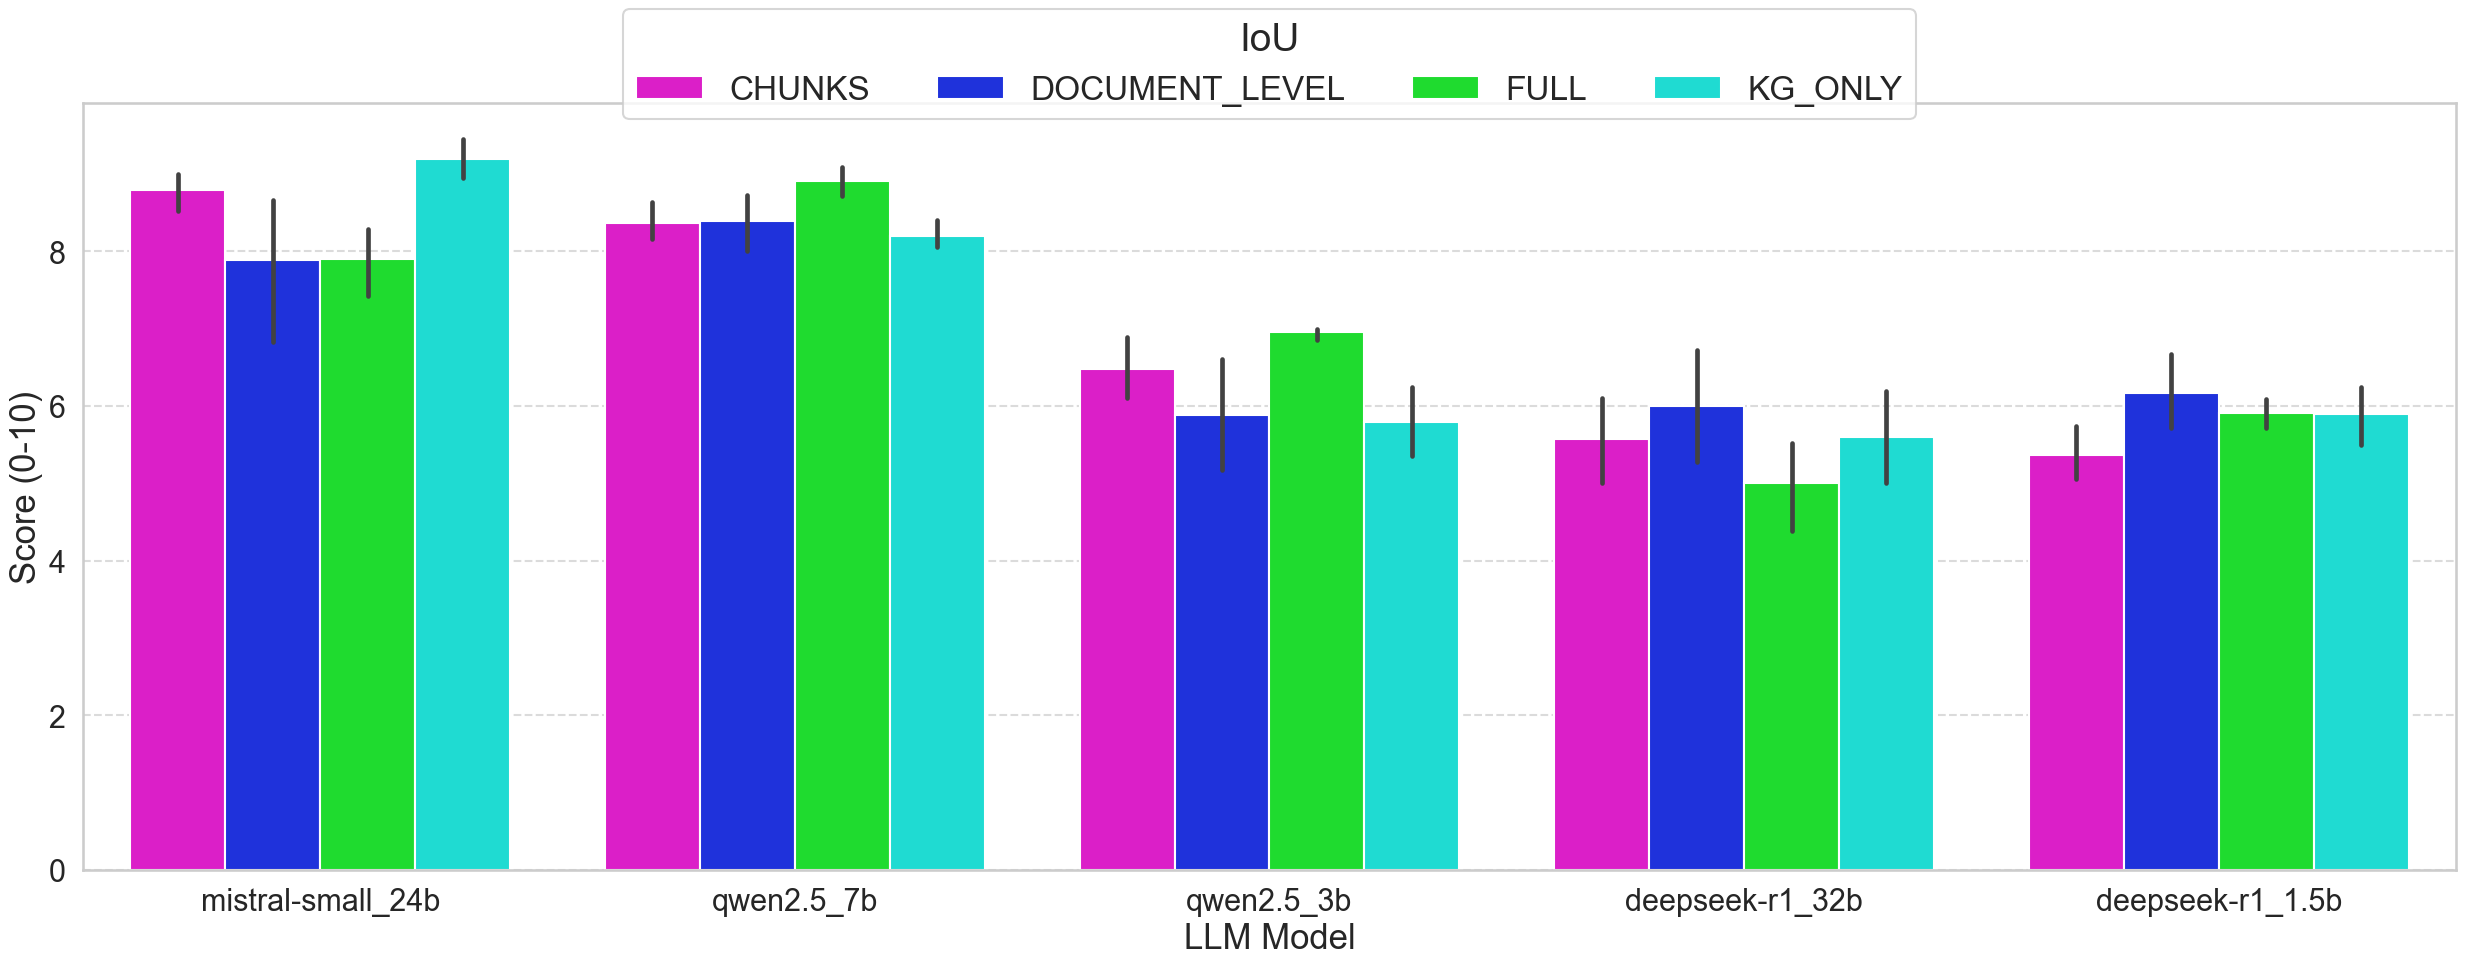

In [333]:
palette = config_seaborn()

# Create figure
plt.figure(figsize=(25, 10))

# Create grouped bar plot
ax = sns.barplot(
    data=combined_df,
    x='model_name',
    y='score',
    hue='response_type',
    palette=palette
)

# Customize plot
# plt.title('Statistical Measures Across Embedding Models', pad=20, size=14)
plt.xlabel('LLM Model', size=25)
plt.ylabel('Score (0-10)', size=25)

# Rotate x-axis labels
plt.xticks(rotation=0, fontsize=22)
plt.yticks(fontsize=22)

# Adjust legend
plt.legend(
    title='IoU',
    bbox_to_anchor=(0.5, 1.05),
    loc='center',
    ncol=4,
    frameon=True,
    fontsize=24,
    title_fontsize=28
)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

plt.savefig('./plots/model_performance.png', dpi=300)
# Show plot
plt.show()

In [334]:
combined_df.head(2)

,model_name,rank,score,reasoning,question_id,access_level,response_type,meta_analysis
0,mistral-small_24b,1,9,This response provides a well-structured and c...,0,admin,CHUNKS,The evaluations highlight that the higher-rank...
1,qwen2.5_7b,2,8,This response discusses important aspects of C...,0,admin,CHUNKS,The evaluations highlight that the higher-rank...


# Embeddings

In [194]:
import ollama
import numpy as np

def get_embeddings(text: str) -> List[float]:
    """
    Get embeddings for text using ollama's all-minilm model.
    
    Args:
        text: Text to embed
        
    Returns:
        List[float]: Embedding vector
    """
    response = ollama.embeddings(
        model='all-minilm:33m',
        prompt=text
    )
    return response['embedding']

def create_embeddings_dataframe() -> pd.DataFrame:
    """
    Create a DataFrame containing embeddings for all LLM responses along with metadata.
    
    Returns:
        pd.DataFrame: DataFrame with columns for model name, filename, and embedding values
    """
    # Get file structure
    output_structure = get_llm_output_structure()
    
    # Lists to store data
    data = []
    
    # Process each file
    for model_name, files in output_structure.items():
        for file_name in files:
            try:
                # Read content
                content = read_llm_response(file_name)
                
                # Get embeddings
                embedding = get_embeddings(content)
                
                # Store data
                data.append({
                    'model': model_name,
                    'filename': file_name.split('/')[-1],  # Just the filename without path
                    'embedding': embedding
                })
                
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Expand embedding column into separate columns
    embedding_df = pd.DataFrame(df['embedding'].tolist(), 
                              columns=[f'dim_{i}' for i in range(len(df['embedding'].iloc[0]))])
    
    # Combine metadata with embeddings
    result_df = pd.concat([
        df[['model', 'filename']],
        embedding_df
    ], axis=1)
    
    return result_df

# Create and display the DataFrame
embeddings_df = create_embeddings_dataframe()
print("\nDataFrame Shape:", embeddings_df.shape)
# print("\nFirst few rows:")
# print(embeddings_df.head())

# Optionally save to parquet for later use
embeddings_df.to_parquet('./results/response_embeddings.parquet')
embeddings_df.head()


DataFrame Shape: (400, 386)


,model,filename,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,...,dim_374,dim_375,dim_376,dim_377,dim_378,dim_379,dim_380,dim_381,dim_382,dim_383
0,qwen2.5_7b,CHUNKS_admin_0_1.txt,-0.075566,0.119131,-0.036106,-0.095838,-0.049041,0.003664,-0.127176,0.092244,...,-0.113079,0.008026,0.111015,-0.082428,0.148435,-0.000946,0.015064,0.055559,-0.129441,0.107625
1,qwen2.5_7b,CHUNKS_admin_1_1.txt,-0.008544,-0.101055,-0.130910,-0.054039,0.110466,-0.068998,-0.068796,0.039880,...,0.184230,0.196043,0.064503,-0.083653,-0.010190,0.024736,0.163483,0.089139,-0.094404,-0.092834
2,qwen2.5_7b,CHUNKS_admin_2_1.txt,0.025271,-0.199228,0.005019,0.219409,0.082700,-0.117323,-0.105174,0.076461,...,0.116590,0.017078,-0.158439,-0.036856,-0.027145,0.094577,-0.118003,-0.053782,-0.151496,0.009665
3,qwen2.5_7b,CHUNKS_admin_3_1.txt,0.070269,0.026260,-0.095843,0.056919,0.190134,-0.027714,-0.125104,0.045174,...,0.095337,0.170429,0.162762,-0.050768,-0.128579,0.012660,-0.079618,0.123970,-0.122808,-0.058790
4,qwen2.5_7b,CHUNKS_admin_4_1.txt,0.073119,-0.056663,-0.111264,-0.087591,0.004742,-0.318034,-0.320232,-0.027044,...,0.121301,0.161043,-0.056585,0.054711,0.090903,0.069179,0.044614,-0.135994,0.010154,-0.005580


# Visualization

In [195]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.graph_objects as go

def create_reduced_dim_plots(df: pd.DataFrame, method: str = 'pca', n_components: int = 2) -> go.Figure:
    """
    Create dimensionality reduction plots using either PCA or t-SNE.
    
    Args:
        df: DataFrame containing embeddings and metadata
        method: Reduction method ('pca' or 'tsne')
        n_components: Number of components for reduction
        
    Returns:
        go.Figure: Interactive plotly figure
    """
    # Get embedding columns
    embedding_cols = [col for col in df.columns if col.startswith('dim_')]
    
    # Perform dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=n_components)
        reduced_data = reducer.fit_transform(df[embedding_cols])
        explained_var = reducer.explained_variance_ratio_
        title = f'PCA Visualization (Explained variance: {sum(explained_var):.2%})'
    else:  # t-SNE
        reducer = TSNE(n_components=n_components, random_state=42)
        reduced_data = reducer.fit_transform(df[embedding_cols])
        title = 'T-SNE Visualization'
    
    # Create DataFrame with reduced dimensions
    plot_df = pd.DataFrame(
        reduced_data,
        columns=[f'Component_{i+1}' for i in range(n_components)]
    )
    
    # Add metadata
    plot_df['model'] = df['model']
    plot_df['filename'] = df['filename']
    
    # Extract type from filename (CHUNKS, DOCUMENT_LEVEL, etc.)
    plot_df['response_type'] = plot_df['filename'].apply(lambda x: x.split('_')[0])
    
    # Create hover text
    plot_df['hover_text'] = plot_df.apply(
        lambda row: f"Model: {row['model']}<br>File: {row['filename']}<br>Type: {row['response_type']}", 
        axis=1
    )
    
    # Create figure
    fig = px.scatter(
        plot_df,
        x='Component_1',
        y='Component_2',
        color='model',
        symbol='response_type',
        hover_data=['filename'],
        title=title,
        labels={
            'Component_1': f'{method.upper()} Component 1',
            'Component_2': f'{method.upper()} Component 2'
        }
    )
    
    # Update layout
    fig.update_layout(
        height=800,
        width=1200,
        template='plotly_white',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    return fig

In [196]:
# Create both visualizations
pca_fig = create_reduced_dim_plots(embeddings_df, method='pca')
tsne_fig = create_reduced_dim_plots(embeddings_df, method='tsne')

# Display figures
# pca_fig.show()
# tsne_fig.show()

# Optionally save the figures
pca_fig.write_html("./results/pca_visualization.html")
tsne_fig.write_html("./results/tsne_visualization.html")

## Response depended

In [197]:
def create_reduced_dim_plots_by_type(df: pd.DataFrame, method: str = 'pca', n_components: int = 2) -> Dict[str, go.Figure]:
    """
    Create separate dimensionality reduction plots for each response type.
    
    Args:
        df: DataFrame containing embeddings and metadata
        method: Reduction method ('pca' or 'tsne')
        n_components: Number of components for reduction
        
    Returns:
        Dict[str, go.Figure]: Dictionary mapping response types to their figures
    """
    # Get embedding columns
    embedding_cols = [col for col in df.columns if col.startswith('dim_')]
    
    # Perform dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=n_components)
        reduced_data = reducer.fit_transform(df[embedding_cols])
        explained_var = reducer.explained_variance_ratio_
        title_prefix = f'PCA Visualization (Explained variance: {sum(explained_var):.2%})'
    else:  # t-SNE
        reducer = TSNE(n_components=n_components, random_state=42)
        reduced_data = reducer.fit_transform(df[embedding_cols])
        title_prefix = 'T-SNE Visualization'
    
    # Create DataFrame with reduced dimensions
    plot_df = pd.DataFrame(
        reduced_data,
        columns=[f'Component_{i+1}' for i in range(n_components)]
    )
    
    # Add metadata
    plot_df['model'] = df['model']
    plot_df['filename'] = df['filename']
    plot_df['response_type'] = df['filename'].apply(lambda x: x.split('_')[0])
    
    # Create hover text
    plot_df['hover_text'] = plot_df.apply(
        lambda row: f"Model: {row['model']}<br>File: {row['filename']}", 
        axis=1
    )
    
    # Create separate figures for each response type
    figures = {}
    for response_type in plot_df['response_type'].unique():
        type_df = plot_df[plot_df['response_type'] == response_type]
        
        fig = px.scatter(
            type_df,
            x='Component_1',
            y='Component_2',
            color='model',
            hover_data=['filename'],
            title=f"{title_prefix} - {response_type}",
            labels={
                'Component_1': f'{method.upper()} Component 1',
                'Component_2': f'{method.upper()} Component 2'
            }
        )
        
        # Update layout
        fig.update_layout(
            height=600,
            width=800,
            template='plotly_white',
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            )
        )
        
        figures[response_type] = fig
    
    return figures

# Create visualizations for both PCA and t-SNE
pca_figs = create_reduced_dim_plots_by_type(embeddings_df, method='pca')
tsne_figs = create_reduced_dim_plots_by_type(embeddings_df, method='tsne')

In [198]:
# Display all figures
# print("\nPCA Visualizations:")
# for response_type, fig in pca_figs.items():
#     print(f"\n{response_type}:")
#     fig.show()
    
# print("\nT-SNE Visualizations:")
# for response_type, fig in tsne_figs.items():
#     print(f"\n{response_type}:")
#     fig.show()

# Save all figures
for response_type, fig in pca_figs.items():
    fig.write_html(f"./results/pca_visualization_{response_type.lower()}.html")
    
for response_type, fig in tsne_figs.items():
    fig.write_html(f"./results/tsne_visualization_{response_type.lower()}.html")

## Similarity

In [199]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def create_similarity_matrix(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a DataFrame containing cosine similarities between all embeddings.
    
    Args:
        df: DataFrame containing embeddings and metadata
        
    Returns:
        pd.DataFrame: DataFrame with cosine similarities and metadata
    """
    # Get embedding columns
    embedding_cols = [col for col in df.columns if col.startswith('dim_')]
    
    # Calculate cosine similarity matrix
    similarities = cosine_similarity(df[embedding_cols])
    
    # Create identifiers for each row
    identifiers = df.apply(
        lambda row: f"{row['model']} - {row['filename']}", 
        axis=1
    ).values
    
    # Create similarity DataFrame with identifiers
    similarity_df = pd.DataFrame(
        similarities,
        index=identifiers,
        columns=identifiers
    )
    
    return similarity_df

# Create similarity matrix
similarity_df = create_similarity_matrix(embeddings_df)

# Display sample of the matrix
print("\nSimilarity Matrix Shape:", similarity_df.shape)
# print("\nSample of Similarity Matrix:")
# print(similarity_df.iloc[:5, :5])

# Save to parquet
similarity_df.to_parquet('./results/response_similarities.parquet')

# Optional: Find most similar pairs (excluding self-similarity)
def get_top_similarities(sim_df: pd.DataFrame, n: int = 10) -> pd.DataFrame:
    """
    Get the top N most similar pairs of responses.
    
    Args:
        sim_df: Similarity matrix DataFrame
        n: Number of top pairs to return
        
    Returns:
        pd.DataFrame: DataFrame with top similar pairs
    """
    # Create pairs DataFrame
    pairs = []
    for i in range(len(sim_df)):
        for j in range(i + 1, len(sim_df)):  # Only upper triangle to avoid duplicates
            pairs.append({
                'response1': sim_df.index[i],
                'response2': sim_df.index[j],
                'similarity': sim_df.iloc[i, j]
            })
    
    pairs_df = pd.DataFrame(pairs)
    return pairs_df.nlargest(n, 'similarity')

# Get top similar pairs
top_pairs = get_top_similarities(similarity_df, n=20)
print("\nTop 20 Most Similar Pairs:")
top_pairs.head()


Similarity Matrix Shape: (400, 400)

Top 20 Most Similar Pairs:


,response1,response2,similarity
77918,deepseek-r1_32b - CHUNKS_user1_8_1.txt,deepseek-r1_32b - DOCUMENT_LEVEL_admin_8_1.txt,1.0
77938,deepseek-r1_32b - CHUNKS_user1_8_1.txt,deepseek-r1_32b - FULL_admin_8_1.txt,1.0
77958,deepseek-r1_32b - CHUNKS_user1_8_1.txt,deepseek-r1_32b - KG_ONLY_admin_8_1.txt,1.0
78493,deepseek-r1_32b - DOCUMENT_LEVEL_admin_8_1.txt,deepseek-r1_32b - FULL_admin_8_1.txt,1.0
78513,deepseek-r1_32b - DOCUMENT_LEVEL_admin_8_1.txt,deepseek-r1_32b - KG_ONLY_admin_8_1.txt,1.0


In [200]:
def create_similarity_pairs_df(similarity_df: pd.DataFrame) -> pd.DataFrame:
    """
    Transform similarity matrix into a long-format DataFrame with paired responses.
    
    Args:
        similarity_df: DataFrame containing similarity matrix
        
    Returns:
        pd.DataFrame: Long-format DataFrame with columns for response pairs and their similarity
    """
    # Create empty lists to store the data
    pairs = []
    
    # Iterate through upper triangle of matrix (excluding diagonal)
    for i in range(len(similarity_df)):
        for j in range(i + 1, len(similarity_df)):
            # Get response identifiers
            response1 = similarity_df.index[i]
            response2 = similarity_df.columns[j]
            
            # Split identifiers into model and filename
            response1_model, response1_filename = response1.split(" - ", 1)
            response2_model, response2_filename = response2.split(" - ", 1)
            
            # Get similarity score
            similarity = similarity_df.iloc[i, j]
            
            # Add to pairs list
            pairs.append({
                'response_1_model': response1_model,
                'response_1_filename': response1_filename,
                'response_2_model': response2_model,
                'response_2_filename': response2_filename,
                'similarity': similarity
            })
    
    # Create DataFrame from pairs
    pairs_df = pd.DataFrame(pairs)
    
    # Sort by similarity in descending order
    pairs_df = pairs_df.sort_values('similarity', ascending=False)
    
    return pairs_df

# Create the transformed DataFrame
similarity_pairs_df = create_similarity_pairs_df(similarity_df)

# Display sample and save
print("\nShape of transformed DataFrame:", similarity_pairs_df.shape)
print("\nSample of highest similarity pairs:")
# print(similarity_pairs_df.head())

# Save to CSV
similarity_pairs_df.to_csv('./results/response_similarity_pairs.csv', index=False)
similarity_pairs_df


Shape of transformed DataFrame: (79800, 5)

Sample of highest similarity pairs:


,response_1_model,response_1_filename,response_2_model,response_2_filename,similarity
77958,deepseek-r1_32b,CHUNKS_user1_8_1.txt,deepseek-r1_32b,KG_ONLY_admin_8_1.txt,1.000000
77938,deepseek-r1_32b,CHUNKS_user1_8_1.txt,deepseek-r1_32b,FULL_admin_8_1.txt,1.000000
78493,deepseek-r1_32b,DOCUMENT_LEVEL_admin_8_1.txt,deepseek-r1_32b,FULL_admin_8_1.txt,1.000000
79323,deepseek-r1_32b,FULL_admin_8_1.txt,deepseek-r1_32b,KG_ONLY_admin_8_1.txt,1.000000
77918,deepseek-r1_32b,CHUNKS_user1_8_1.txt,deepseek-r1_32b,DOCUMENT_LEVEL_admin_8_1.txt,1.000000
...,...,...,...,...,...
36304,mistral-small_24b,DOCUMENT_LEVEL_admin_4_1.txt,deepseek-r1_1.5b,DOCUMENT_LEVEL_admin_9_1.txt,-0.104718
44689,mistral-small_24b,FULL_user1_4_1.txt,deepseek-r1_1.5b,DOCUMENT_LEVEL_admin_9_1.txt,-0.105722
71369,deepseek-r1_1.5b,DOCUMENT_LEVEL_admin_9_1.txt,deepseek-r1_32b,DOCUMENT_LEVEL_user1_4_1.txt,-0.111688
71349,deepseek-r1_1.5b,DOCUMENT_LEVEL_admin_9_1.txt,deepseek-r1_32b,CHUNKS_user1_4_1.txt,-0.113390


## Inter-Model Consistency Analysis:

In [201]:
def analyze_model_consistency(similarity_pairs_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze how consistent each model's responses are with itself and other models.
    
    Args:
        similarity_pairs_df: DataFrame with similarity pairs
        
    Returns:
        pd.DataFrame: Statistics about model consistency
    """
    # Self-consistency (how similar are responses from the same model)
    self_consistency = similarity_pairs_df[
        similarity_pairs_df['response_1_model'] == similarity_pairs_df['response_2_model']
    ].groupby('response_1_model')['similarity'].agg(['mean', 'std']).round(4)
    
    # Cross-model agreement
    cross_model = similarity_pairs_df[
        similarity_pairs_df['response_1_model'] != similarity_pairs_df['response_2_model']
    ].groupby(['response_1_model', 'response_2_model'])['similarity'].mean().round(4)
    
    return self_consistency, cross_model

# Get consistency metrics
self_consistency, cross_model = analyze_model_consistency(similarity_pairs_df)
print("\nModel Self-Consistency:")
print(self_consistency)
print("\nCross-Model Agreement:")
cross_model.reset_index()


Model Self-Consistency:
                     mean     std
response_1_model                 
deepseek-r1_1.5b   0.3150  0.1793
deepseek-r1_32b    0.3404  0.2116
mistral-small_24b  0.3323  0.2014
qwen2.5_3b         0.3372  0.1766
qwen2.5_7b         0.3594  0.1810

Cross-Model Agreement:


,response_1_model,response_2_model,similarity
0,deepseek-r1_1.5b,deepseek-r1_32b,0.3237
1,mistral-small_24b,deepseek-r1_1.5b,0.3207
2,mistral-small_24b,deepseek-r1_32b,0.3354
3,mistral-small_24b,qwen2.5_3b,0.3314
4,qwen2.5_3b,deepseek-r1_1.5b,0.3213
5,qwen2.5_3b,deepseek-r1_32b,0.3321
6,qwen2.5_7b,deepseek-r1_1.5b,0.3329
7,qwen2.5_7b,deepseek-r1_32b,0.3440
8,qwen2.5_7b,mistral-small_24b,0.3424
9,qwen2.5_7b,qwen2.5_3b,0.3516


## Response Type Analysis:

In [202]:
def analyze_response_types(similarity_pairs_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze how different response types (CHUNKS, DOCUMENT_LEVEL, etc.) compare.
    
    Args:
        similarity_pairs_df: DataFrame with similarity pairs
        
    Returns:
        pd.DataFrame: Statistics about response type consistency
    """
    # Extract response types
    similarity_pairs_df['response_1_type'] = similarity_pairs_df['response_1_filename'].apply(
        lambda x: x.split('_')[0]
    )
    similarity_pairs_df['response_2_type'] = similarity_pairs_df['response_2_filename'].apply(
        lambda x: x.split('_')[0]
    )
    
    # Analyze consistency within and between response types
    type_analysis = similarity_pairs_df.groupby(
        ['response_1_type', 'response_2_type', 'response_1_model']
    )['similarity'].agg(['mean', 'std', 'count']).round(4)
    
    return type_analysis

# Get response type analysis
type_analysis = analyze_response_types(similarity_pairs_df)
print("\nResponse Type Analysis:")
type_analysis.reset_index()


Response Type Analysis:


,response_1_type,response_2_type,response_1_model,mean,std,count
0,CHUNKS,CHUNKS,deepseek-r1_1.5b,0.3347,0.1890,590
1,CHUNKS,CHUNKS,deepseek-r1_32b,0.3286,0.1938,190
2,CHUNKS,CHUNKS,mistral-small_24b,0.3438,0.1876,1390
3,CHUNKS,CHUNKS,qwen2.5_3b,0.3424,0.1817,990
4,CHUNKS,CHUNKS,qwen2.5_7b,0.3507,0.1831,1790
...,...,...,...,...,...,...
69,KG,KG,deepseek-r1_1.5b,0.3106,0.1896,590
70,KG,KG,deepseek-r1_32b,0.3039,0.2045,190
71,KG,KG,mistral-small_24b,0.3385,0.1820,1390
72,KG,KG,qwen2.5_3b,0.3204,0.1673,990


## Question-Level Analysis:

In [203]:
def analyze_question_responses(similarity_pairs_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compare how different models answered the same questions.
    
    Args:
        similarity_pairs_df: DataFrame with similarity pairs
        
    Returns:
        pd.DataFrame: Question-level analysis
    """
    # Extract question numbers
    similarity_pairs_df['question_1'] = similarity_pairs_df['response_1_filename'].apply(
        lambda x: '_'.join(x.split('_')[1:3])  # Gets e.g., 'admin_1'
    )
    similarity_pairs_df['question_2'] = similarity_pairs_df['response_2_filename'].apply(
        lambda x: '_'.join(x.split('_')[1:3])
    )
    
    # Analyze same-question responses across models
    question_analysis = similarity_pairs_df[
        similarity_pairs_df['question_1'] == similarity_pairs_df['question_2']
    ].groupby(['question_1', 'response_1_model', 'response_2_model'])['similarity'].mean().round(4)
    
    return question_analysis

# Get question-level analysis
question_analysis = analyze_question_responses(similarity_pairs_df)
print("\nQuestion-Level Analysis:")
question_analysis.reset_index()


Question-Level Analysis:


,question_1,response_1_model,response_2_model,similarity
0,LEVEL_admin,deepseek-r1_1.5b,deepseek-r1_1.5b,0.2607
1,LEVEL_admin,deepseek-r1_1.5b,deepseek-r1_32b,0.3230
2,LEVEL_admin,deepseek-r1_32b,deepseek-r1_32b,0.3077
3,LEVEL_admin,mistral-small_24b,deepseek-r1_1.5b,0.3051
4,LEVEL_admin,mistral-small_24b,deepseek-r1_32b,0.3368
...,...,...,...,...
355,user1_9,qwen2.5_7b,deepseek-r1_1.5b,0.8276
356,user1_9,qwen2.5_7b,deepseek-r1_32b,0.8747
357,user1_9,qwen2.5_7b,mistral-small_24b,0.8329
358,user1_9,qwen2.5_7b,qwen2.5_3b,0.7939


## Viz

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_model_comparisons(similarity_pairs_df: pd.DataFrame):
    """
    Create heatmap visualizations of model similarities.
    """
    # Create model similarity matrix
    model_similarities = similarity_pairs_df.groupby(
        ['response_1_model', 'response_2_model']
    )['similarity'].mean().unstack()
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        model_similarities, 
        annot=True, 
        cmap='magma',
        center=0,
        fmt='.3f'
    )
    plt.title('Average Response Similarity Between Models')
    plt.tight_layout()
    plt.savefig('./results/model_similarities_heatmap.png')
    plt.close()

# Create visualization
plot_model_comparisons(similarity_pairs_df)